Found 600 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 750 images belonging to 10 classes.
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - accuracy: 0.1283 - loss: 2.8737 - val_accuracy: 0.4667 - val_loss: 1.8445
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 292s 7s/step - accuracy: 0.3483 - loss: 1.9909 - val_accuracy: 0.8000 - val_loss: 1.0874
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.5704 - loss: 1.4223 - val_accuracy: 0.8800 - val_loss: 0.6045
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - accuracy: 0.6585 - loss: 0.9925 - val_accuracy: 0.8733 - val_loss: 0.5208
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - accuracy: 0.7351 - loss: 0.8504 - val_accuracy: 0.8800 - val_loss: 0.3830

Validation Accuracy: 86.00%

Test Accuracy: 88.13%


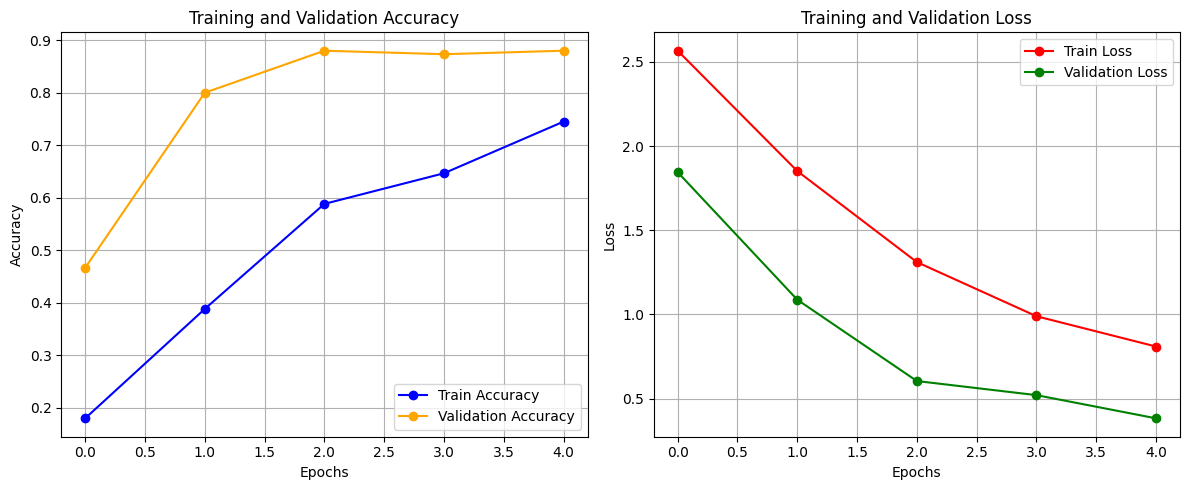

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Dataset path
data_dir = "/kaggle/input/swedishleaf/SwedishLeaf"
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The specified directory {data_dir} does not exist. Please check the path.")

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 10

# Data preprocessing and augmentation
data_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train and validation data generators
train_data_gen = data_gen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data_gen = data_gen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_data_gen = data_gen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



local_weights_path = "/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16 = VGG16(weights=local_weights_path, include_top=False, input_shape=(224, 224, 3))


# Unfreeze the last 4 layers for fine-tuning
for layer in vgg16.layers[:-4]:
    layer.trainable = False
for layer in vgg16.layers[-4:]:
    layer.trainable = True

# Add custom classification head
model = Sequential([
    vgg16,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.8),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data_gen,
    epochs=5,
    validation_data=val_data_gen,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_data_gen, verbose=0)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(test_data_gen, verbose=0)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


def plot_training_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='red', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Example call (assuming `history` is the training history object from Keras)
plot_training_history(history)

